In [56]:
library(dplyr)
library(plotrix)
options(warn = -1)

In [6]:
train_df <- read.csv("../Data/Titanic_train.csv")
head(train_df, 10) 
tail(train_df)
str(train_df)

# 데이터가 어떤 식으로 되어있는지 잘못 입력된건 없는지 확인해야한다. 
## 항구 팩터가 4개 임으로 이상치가 하나 들어가있다 

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,,C


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39,0,5,382652,29.125,,Q
887,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.000,,S
888,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.000,B42,S
889,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NA,1,2,W./C. 6607,23.450,,S
890,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.000,C148,C
891,891,0,3,"Dooley, Mr. Patrick",male,32,0,0,370376,7.750,,Q


'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 891 levels "Abbing, Mr. Anthony",..: 109 191 354 273 16 555 516 625 413 577 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 681 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 148 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


### 컬럼 내용 확인 
- Survived : 생존 여부 (0 = 사망, 1 = 생존 True/False) / 이상치가 있는지 확인해봐야함 / Target컬럼 / 타켓이 숫자면 랜덤포레스트,SVM은 결과를 숫자로 준다
- Pclass : 티켓 등급  (1 = 1등급 객실, 2 = 2등급 , 3 = 3등급) / 타이타닉의 티켓 등급 확인 , 타이타닉의 구조 확인 (3등급은 출입구가 두 개밖에 없었다) 
    1등급은 작위가 있어야함 상류층, 2등급 작위는 없지만 돈은 많음 중산층, 3등급 서민 /  
    딥러닝에 쓸수 있는 정형데이터가 아직 별로 없다. 현재 이미지 같은 비정형데이터에 주로 사용
- SibSp : 함께 탑승한 형제, 자매, 배우자의 수
- Parch : 함께 탑승한 부모, 자식의 수 
- Fare : 운임, 짐에 대한 비용
- Cabin : 선실, 객실 번호
- Embarked : 탑승 항구 / 3곳 C = Chersbourg 오스트리아 (잘 살았음, 베토벤 시절) , Q = Queenstown 영국 , S = Southampton 영국 (영국은 못 살던 시절)

## 컬럼별로 하나씩 확인 작업

In [12]:
# 각 컬럼별 NA 확인
sum(is.na(train_df))
colSums(is.na(train_df))

# AGE에만 177개의 NA가 있다 
177 / 891 # 0.198653198653199 , 20% Age에 채워넣을 데이터, 연관된 데이터가 없다 

[1] 177

PassengerId    Survived      Pclass        Name         Sex         Age 
          0           0           0           0           0         177 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           0           0           0

[1] 0.1986532

In [30]:
# train_df$Age가 NA인 것 빼고 데이터셋 만들기

head(subset(train_df , train_df$Age != 'NA'))
train_df_na <- subset(train_df , !is.na(Age))

## 갯수 확인하기
# 891 - 177 = 714
# nrow(subset(train_df , train_df$Age != 'NA')) = 714

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
7,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S


In [35]:
# Survived 기준으로 Dataset 정렬 
train_df <- arrange(train_df, train_df$Survived)
head(train_df)

# NA 없앤 버전
# arrange(train_df_na, train_df_na$Survived)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,,S
13,0,3,"Saundercock, Mr. William Henry",male,20,0,0,A/5. 2151,8.0500,,S


In [36]:
# 정렬된 크기 확인하기
dim(train_df) # 차원 확인하기 1. row , 2. col

[1] 891  12

## Target Column : Survived 분석 및 확인

In [62]:
# Survived의 생존과 사망 Count 확인 및 비율 계산하기
table(train_df$Survived) 
count(train_df, train_df$Survived)

# 사망자수
nrow(train_df[train_df$Survived == 0 , ])
# 생존자수
nrow(train_df[train_df$Survived == 1 , ])
# 생존자수의 비율
nrow(train_df[train_df$Survived == 1 , ]) / nrow(train_df) * 100

# 피쳐는 특징이 있으면 좋고, 타겟은 비율이 고르면 좋다 (best 1:1이지만 거의 없음)




  0   1 
549 342 

train_df$Survived,n
0,549
1,342


[1] 549

[1] 342

[1] 38.38384

[1] "사망 \n 61.62 %" "생존 \n 38.38 %"

[1] "사망 \n 61.62 %" "생존 \n 38.38 %"

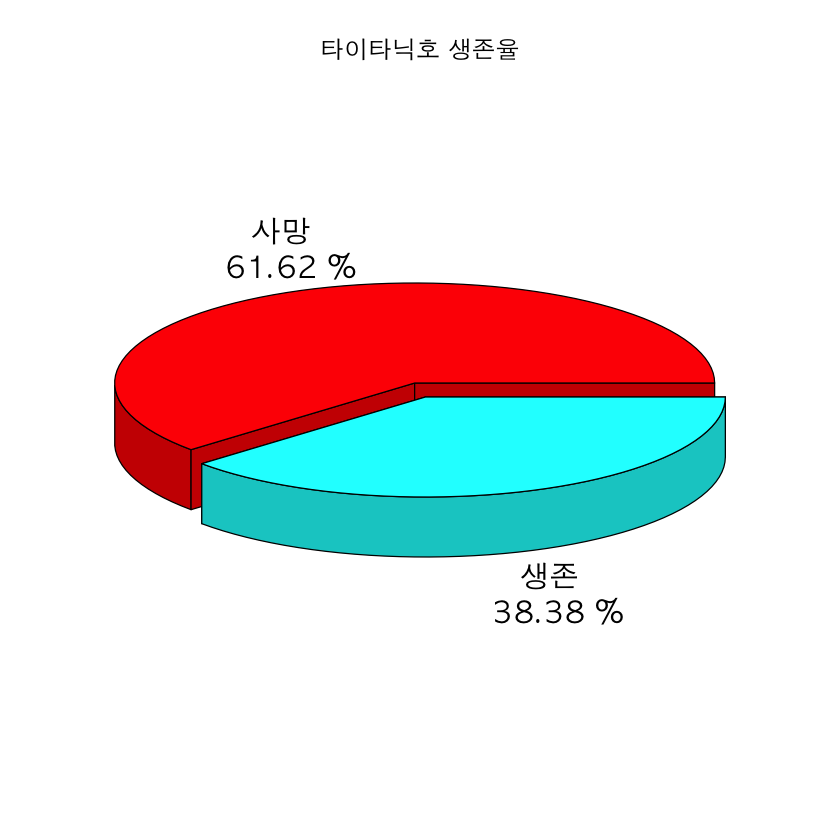

In [64]:
# 타이타닉호 생존율 시각화 
Survive <- count(train_df, train_df$Survived)$n
sub <- c('사망','생존')
ratio <- round(Survive / nrow(train_df) * 100 , 2)
label <- paste(sub, "\n", ratio, "%")

par(family = 'AppleGothic', bg = 'white')
pie3D(Survive, 
    main = "타이타닉호 생존율",
    labels = label,
    col = rainbow(length(Survive)),
    explode = 0.05
)